In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from mlxtend.regressor import StackingRegressor
import warnings
warnings.filterwarnings('ignore')

### Loading data

In [4]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    return X, y

In [5]:
def get_freq_data(X, freq=20, start_point=355):
    X_freq = np.concatenate([X[:, start_point::-freq], X[:, start_point::freq]], axis=1)
    return X_freq

In [6]:
X, y = get_data()

### Pipelines

In [7]:
huber_reg = HuberRegressor(epsilon= 5.09, alpha= 0.0004)
ridge_reg = linear_model.Ridge(solver='saga', max_iter=4000, alpha= 0.582)
lasso_reg = linear_model.Lasso(max_iter=4000, alpha=0.0038, normalize=False)
dt_reg = tree.DecisionTreeRegressor(min_samples_split=7, min_samples_leaf=7, min_weight_fraction_leaf=0.000516, 
                                                                                             max_features='auto')
    
pa_reg = PassiveAggressiveRegressor(max_iter=3600, tol=1e-3)
xgb_reg = xgb.XGBRegressor(objective="reg:linear", alpha= 0.00244, booster='dart', eta= 0.017326, gamma=0.19504, 
                           reg_lambda=0.22451, max_depth=8, verbosity=0)

In [8]:
models = [huber_reg, ridge_reg, lasso_reg, dt_reg, pa_reg, xgb_reg]

### Let's find out how scores depend on frequency of sampling

In [9]:
models_scores = {type(model).__name__:{'r2': [], 'mse': [], 'mae': [], 'rmse': []} for model in models}

In [10]:
models_scores

{'HuberRegressor': {'r2': [], 'mse': [], 'mae': [], 'rmse': []},
 'Ridge': {'r2': [], 'mse': [], 'mae': [], 'rmse': []},
 'Lasso': {'r2': [], 'mse': [], 'mae': [], 'rmse': []},
 'DecisionTreeRegressor': {'r2': [], 'mse': [], 'mae': [], 'rmse': []},
 'PassiveAggressiveRegressor': {'r2': [], 'mse': [], 'mae': [], 'rmse': []},
 'XGBRegressor': {'r2': [], 'mse': [], 'mae': [], 'rmse': []}}

In [11]:
freq_range = range(20, 70, 10)

for freq in freq_range:
    print("Frequency:", freq)
    X, y = get_data()
    X = get_freq_data(X, freq=freq)
    for model in models:    
        model_name = type(model).__name__
        print("Metaregressor:", model_name)
        stregr = StackingRegressor(regressors=models, meta_regressor=model)
        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(stregr, X, y, scoring=scoring, cv=5)
 
        r2_score_mean = scores['test_r2'].mean()
        r2_score_std = scores['test_r2'].std()
        mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
        mse_score_std = scores['test_neg_mean_squared_error'].std()
        mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
        mae_score_std = scores['test_neg_mean_absolute_error'].std()
        rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
        rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()
        
        cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                          (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
#         print('!!!!!!!!')
#         print("TEST")
#         print(models_scores[type(models[0]).__name__]['r2'])
#         print('!!!!!!!!')
        print("95% confindence interval:")
        for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
            models_scores[model_name][metric].append(cur_scores[i])
            print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
        print('----------------------------------')
    print('____________________________________________________________')
    print()

Frequency: 20
Metaregressor: HuberRegressor
95% confindence interval:
r2 score: 0.99944 (+/- 0.00006)
mse score: 0.09025 (+/- 0.00862)
mae score: 0.23302 (+/- 0.00818)
rmse score: 0.30033 (+/- 0.01445)
----------------------------------
Metaregressor: Ridge
95% confindence interval:
r2 score: 0.99944 (+/- 0.00006)
mse score: 0.09097 (+/- 0.00915)
mae score: 0.23386 (+/- 0.00863)
rmse score: 0.30152 (+/- 0.01530)
----------------------------------
Metaregressor: Lasso
95% confindence interval:
r2 score: 0.99941 (+/- 0.00006)
mse score: 0.09606 (+/- 0.00947)
mae score: 0.24016 (+/- 0.00846)
rmse score: 0.30985 (+/- 0.01537)
----------------------------------
Metaregressor: DecisionTreeRegressor
95% confindence interval:
r2 score: 0.99939 (+/- 0.00006)
mse score: 0.09925 (+/- 0.00922)
mae score: 0.24608 (+/- 0.00775)
rmse score: 0.31496 (+/- 0.01466)
----------------------------------
Metaregressor: PassiveAggressiveRegressor
95% confindence interval:
r2 score: 0.99909 (+/- 0.00116)
mse s

### Save our results

In [12]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [61]:
# save_obj(models_scores, 'models_scores')

In [13]:
models_scores = load_obj('models_scores')

### Lets plot our results

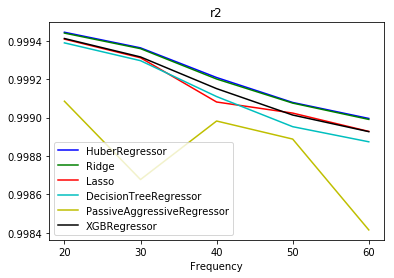

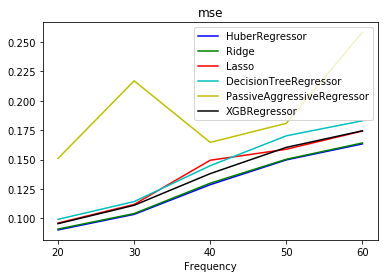

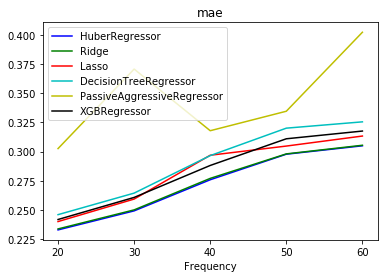

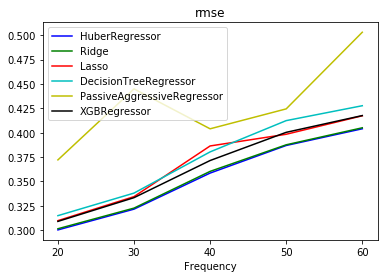

In [47]:
colors = ['b', 'g', 'r', 'c', 'y', 'k']

for metric in ['r2', 'mse', 'mae', 'rmse']:
    for i in range(len(models)):
        plt.title(metric)
        plt.xlabel('Frequency')
        plt.plot(np.array(models_scores[type(models[i]).__name__][metric])[:, 0], color=colors[i])
        plt.xticks([i for i in range(0, len(models) - 1)], [20, 30, 40, 50, 60])
        plt.legend([type(model).__name__ for model in models])
    plt.show()

### Confidence interval

In [74]:
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
 
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None, xticks=freq_range):
    lb = mean + lb
    ub = mean + ub
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
#     plt.xticks(xticks)
    plt.plot(mean, color_mean)

In [104]:
def plot_confidence_interval(metric):
    for i in range(len(models)):
        plt.subplot(321 + i)
        plt.title(type(models[i]).__name__)
        plt.xticks([i for i in range(0, len(models) - 1)], [20, 30, 40, 50, 60])
        plot_mean_and_CI(np.array(models_scores[type(models[i]).__name__][metric])[:, 0],\
                            -np.array(models_scores[type(models[i]).__name__][metric])[:, 1],\
                             np.array(models_scores[type(models[i]).__name__][metric])[:, 1],\
                                 color_mean=colors[i], color_shading=colors[i])

##### R2

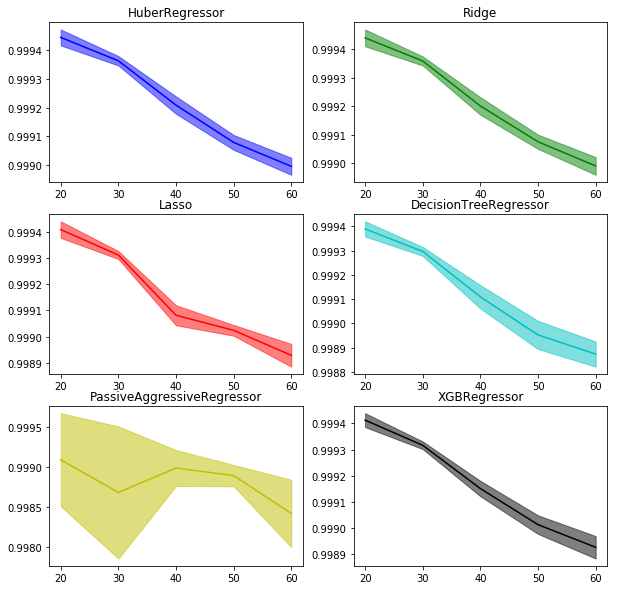

In [105]:
plot_confidence_interval('r2')

##### MSE

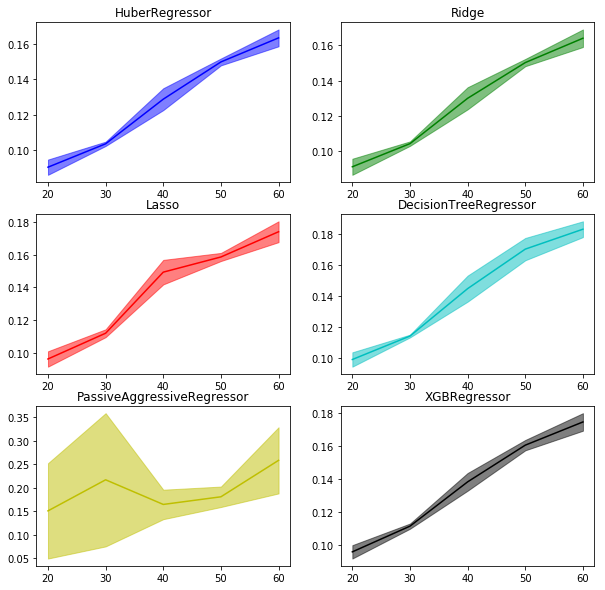

In [99]:
plot_confidence_interval('mse')

##### MAE

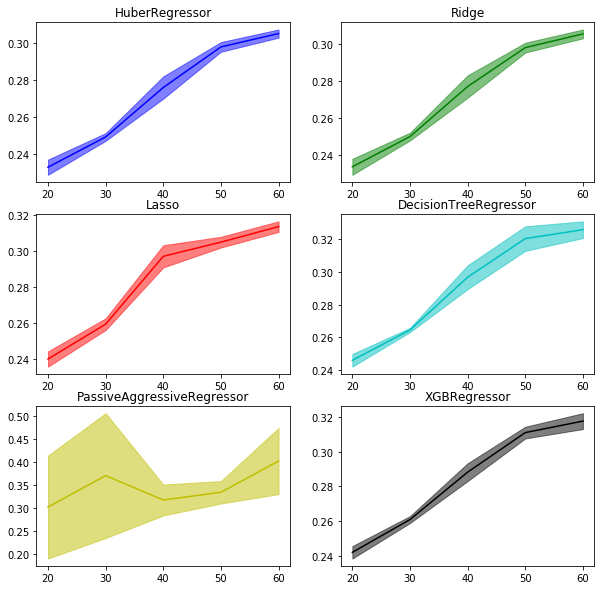

In [100]:
plot_confidence_interval('mae')

##### RMSE

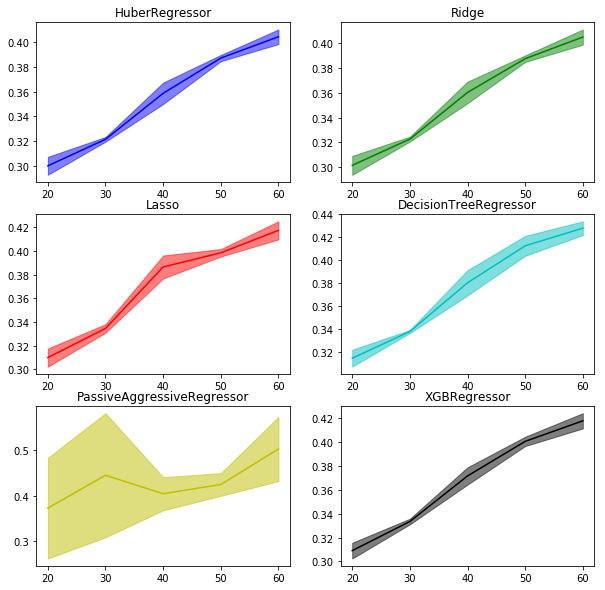

In [101]:
plot_confidence_interval('rmse')